# Classification multi-classe et stacking

On cherche à prédire la note d'un vin avec un classifieur multi-classe puis à améliorer le score obtenu avec une méthode dite de [stacking](https://www.quora.com/What-is-stacking-in-machine-learning).

## Le problème

Il n'est pas évident que les scores des différents modèles qu'on apprend sur chacun des classes soient comparables. Si le modèle n'est pas assez performant, on peut songer à ajouter un dernier modèle qui prend la décision finale en fonction du résultat de chaque modèle.

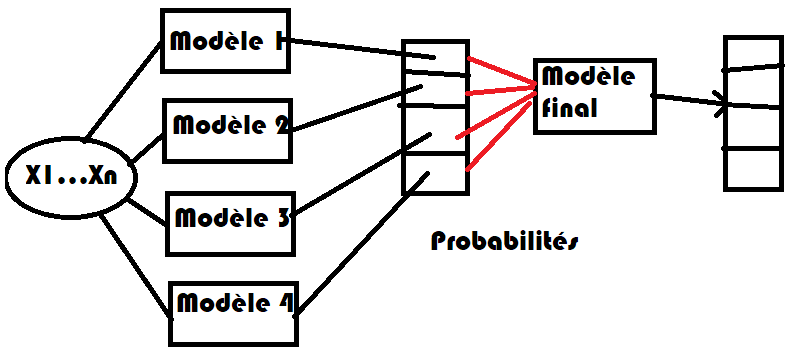

In [1]:
from IPython.display import Image

Image("images/stackmulti.png", width=400)

In [2]:
%matplotlib inline

In [23]:
from teachpyx.datasets import load_wines_dataset

df = load_wines_dataset()
X = df.drop(["quality", "color"], axis=1)
y = df["quality"]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

clr = OneVsRestClassifier(LogisticRegression(max_iter=1500))
clr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1500))

In [7]:
import numpy

numpy.mean(clr.predict(X_test).ravel() == y_test.ravel()) * 100

54.70769230769231

On regarde la matrice de confusion.

In [8]:
from sklearn.metrics import confusion_matrix
import pandas

df = pandas.DataFrame(confusion_matrix(y_test, clr.predict(X_test)))
try:
    df.columns = [str(_) for _ in clr.classes_][: df.shape[1]]
    df.index = [str(_) for _ in clr.classes_][: df.shape[0]]
except ValueError:
    # Il peut arriver qu'une classe ne soit pas représenter
    # lors de l'apprentissage
    print("erreur", df.shape, clr.classes_)
df

,3,4,5,6,7,8,9
3,0,0,3,5,0,1,0
4,0,0,40,18,0,0,0
5,0,0,339,198,0,0,0
6,0,0,184,527,8,0,0
7,0,0,23,210,23,0,0
8,0,0,3,33,9,0,0
9,0,0,0,1,0,0,0


On cale d'abord une random forest sur les données brutes.

In [9]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
numpy.mean(rfc.predict(X_test).ravel() == y_test.ravel()) * 100

68.9846153846154

On cale une random forest avec les sorties de la régression logistique.

In [10]:
rf_train = clr.decision_function(X_train)

rfc_y = RandomForestClassifier()
rfc_y.fit(rf_train, y_train)

RandomForestClassifier()

On calcule le taux d'erreur.

In [11]:
rf_test = clr.decision_function(X_test)
numpy.mean(rfc_y.predict(rf_test).ravel() == y_test.ravel()) * 100

66.83076923076922

C'est presque équivalent à une random forest calée sur les données brutes. On trace les courbes ROC pour la classe 4.

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_lr, tpr_lr, th_lr = roc_curve(y_test == 4, clr.decision_function(X_test)[:, 2])
fpr_rfc, tpr_rfc, th_rfc = roc_curve(y_test == 4, rfc.predict_proba(X_test)[:, 2])
fpr_rfc_y, tpr_rfc_y, th_rfc_y = roc_curve(
    y_test == 4, rfc_y.predict_proba(rf_test)[:, 2]
)
auc_lr = roc_auc_score(y_test == 4, clr.decision_function(X_test)[:, 2])
auc_rfc = roc_auc_score(y_test == 4, rfc.predict_proba(X_test)[:, 2])
auc_rfc_y = roc_auc_score(y_test == 4, rfc_y.predict_proba(rf_test)[:, 2])
auc_lr, auc_rfc, auc_rfc_y

(0.7269546464802059, 0.6626763197852255, 0.6701197104064432)

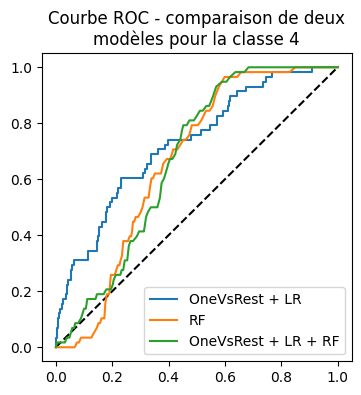

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], "k--")
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="RF")
ax.plot(fpr_rfc_y, tpr_rfc_y, label="OneVsRest + LR + RF")
ax.set_title("Courbe ROC - comparaison de deux\nmodèles pour la classe 4")
ax.legend();

La courbe ROC ne montre rien de probant. Il faudrait vérifier avec une cross-validation qu'il serait pratique de faire avec un [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) mais ceux-ci n'acceptent qu'un seul prédicteur final.

In [14]:
from sklearn.pipeline import make_pipeline

try:
    pipe = make_pipeline(
        OneVsRestClassifier(LogisticRegression(max_iter=1500)), RandomForestClassifier()
    )
except Exception as e:
    print("ERREUR :")
    print(e)

On construit une ROC sur toutes les classes.

In [15]:
fpr_lr, tpr_lr, th_lr = roc_curve(
    y_test == clr.predict(X_test),
    clr.predict_proba(X_test).max(axis=1),
    drop_intermediate=False,
)
fpr_rfc, tpr_rfc, th_rfc = roc_curve(
    y_test == rfc.predict(X_test),
    rfc.predict_proba(X_test).max(axis=1),
    drop_intermediate=False,
)
fpr_rfc_y, tpr_rfc_y, th_rfc_y = roc_curve(
    y_test == rfc_y.predict(rf_test),
    rfc_y.predict_proba(rf_test).max(axis=1),
    drop_intermediate=False,
)
auc_lr = roc_auc_score(
    y_test == clr.predict(X_test), clr.decision_function(X_test).max(axis=1)
)
auc_rfc = roc_auc_score(
    y_test == rfc.predict(X_test), rfc.predict_proba(X_test).max(axis=1)
)
auc_rfc_y = roc_auc_score(
    y_test == rfc_y.predict(rf_test), rfc_y.predict_proba(rf_test).max(axis=1)
)
auc_lr, auc_rfc, auc_rfc_y

(0.5556820682740744, 0.7318154142418192, 0.7349919877544187)

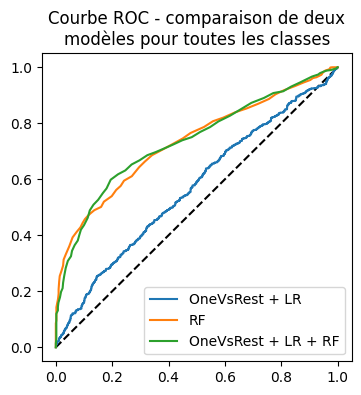

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], "k--")
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="RF")
ax.plot(fpr_rfc_y, tpr_rfc_y, label="OneVsRest + LR + RF")
ax.set_title("Courbe ROC - comparaison de deux\nmodèles pour toutes les classes")
ax.legend();

Sur ce modèle, le score produit par le classifieur final paraît plus partinent que le score obtenu en prenant le score maximum sur toutes les classes. On tente une dernière approche où le modèle final doit valider ou non la réponse : c'est un classifieur binaire. Avec celui-ci, tous les classifieurs estimés sont binaires.

In [17]:
rf_train_bin = clr.decision_function(X_train)
y_train_bin = clr.predict(X_train) == y_train
rfc = RandomForestClassifier()
rfc.fit(rf_train_bin, y_train_bin)

RandomForestClassifier()

On regarde les premières réponses.

In [18]:
rf_test_bin = clr.decision_function(X_test)
rfc.predict_proba(rf_test_bin)[:3]

array([[0.42, 0.58],
       [0.89, 0.11],
       [0.64, 0.36]])

In [19]:
y_test_bin = clr.predict(X_test) == y_test

In [20]:
fpr_rfc_bin, tpr_rfc_bin, th_rfc_bin = roc_curve(
    y_test_bin, rfc.predict_proba(rf_test_bin)[:, 1]
)
auc_rfc_bin = roc_auc_score(y_test_bin, rfc.predict_proba(rf_test_bin)[:, 1])
auc_lr, auc_rfc_bin

(0.5556820682740744, 0.7731918190932655)

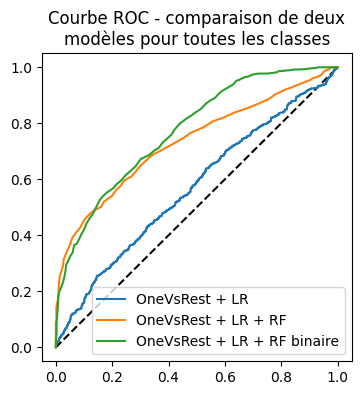

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], "k--")
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="OneVsRest + LR + RF")
ax.plot(fpr_rfc_bin, tpr_rfc_bin, label="OneVsRest + LR + RF binaire")
ax.set_title("Courbe ROC - comparaison de deux\nmodèles pour toutes les classes")
ax.legend();

Un peu mieux mais il faudrait encore valider avec une validation croisée et plusieurs jeux de données, y compris artificiels. Il reste néanmoins l'idée.

## Automatisation avec une implémentation

Comme c'est fastidieux de faire tout cela, on crée un pipeline. *scikit-learn* a introduit le modèle [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier).

In [31]:
from sklearn.ensemble import StackingClassifier

model = StackingClassifier(
    [
        ("ovrlr", LogisticRegression(solver="liblinear")),
        ("rf", RandomForestClassifier()),
    ]
)
model.fit(X_train, y_train)

/home/xadupre/install/scikit-learn/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/xadupre/install/scikit-learn/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


StackingClassifier(estimators=[('ovrlr',
                                LogisticRegression(solver='liblinear')),
                               ('rf', RandomForestClassifier())])

In [32]:
fpr_pipe, tpr_pipe, th_pipe = roc_curve(
    y_test == model.predict(X_test),
    model.predict_proba(X_test).max(axis=1),
    drop_intermediate=False,
)
auc_pipe = roc_auc_score(
    y_test == model.predict(X_test), model.predict_proba(X_test).max(axis=1)
)
auc_pipe

0.7196235911146174

La validation croisée a été escamotée par gain de temps mais faire l'impasse est risquée dans le cas général.